# Generate active galaxy

Finall, in this example we're going to demonstrate how to make a composite galaxy, including with imaging. For more information on defining parametric morphology see the Imaging examples.

In [1]:
from unyt import K, Msun, Myr, deg, kelvin, kpc, yr

from synthesizer.emission_models import (
    AttenuatedEmission,
    DustEmission,
    PacmanEmission,
    UnifiedAGN,
)
from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.emission_models.dust.emission import Greybody
from synthesizer.filters import UVJ
from synthesizer.grid import Grid
from synthesizer.parametric import SFH, BlackHole, Stars, ZDist
from synthesizer.parametric.galaxy import Galaxy
from synthesizer.parametric.morphology import Sersic2D

Let's begin by defining the geometry of the images:

In [2]:
# Define geometry of the images
resolution = 0.01 * kpc  # resolution in kpc
npix = 301
fov = resolution * npix

Define the `grid_dir`:

In [3]:
grid_dir = "../../../tests/test_grid"

### Diffuse ISM dust

Later on we're going to apply "diffuse" (ISM) dust attenuation to both the stars and blackholes so let's define these now. Note, these could be different for each component.

In [4]:
tau_v = 0.5
# dust curve slope
alpha = -1.0
dust_curve = PowerLaw(slope=alpha)
dust_emission_model = Greybody(30 * K, 1.2)

## The Stars

Let's first build the stellar component of our galaxy, including setting the morphology so we can make an image later.

First define the grid. We need this to create our star formation and metal enrichment history.

In [5]:
grid_name = "test_grid"
grid = Grid(grid_name, grid_dir=grid_dir)

Let's define our star formation and metal enrichment history:

In [6]:
stellar_mass = 10**10 * Msun
sfh = SFH.Constant(max_age=100 * Myr)
metal_dist = ZDist.Normal(mean=0.01, sigma=0.05)

Next, let's define the morphology:

In [7]:
morph = Sersic2D(
    r_eff=1.0 * kpc, sersic_index=1.0, ellipticity=0.5, theta=35.0
)

Now let's initialise our stars object:

In [8]:
# Get the 2D star formation and metal enrichment history for the
# given SPS grid. This is (age, Z).
stars = Stars(
    grid.log10age,
    grid.metallicity,
    sf_hist=sfh,
    metal_dist=metal_dist,
    initial_mass=stellar_mass,
    morphology=morph,
)

Now generate the stellar spectra:

In [9]:
# Get the model
pacman = PacmanEmission(
    grid=grid,
    tau_v=tau_v,
    dust_curve=dust_curve,
    dust_emission=dust_emission_model,
)

# Get the spectra
stars.get_spectra(pacman)

/opt/hostedtoolcache/Python/3.10.15/x64/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: overflow encountered in exp
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)
/opt/hostedtoolcache/Python/3.10.15/x64/lib/python3.10/site-packages/unyt/array.py:1949: RuntimeWarning: overflow encountered in multiply
  out_arr = func(


## The blackholes

Let's define the properties of our blackholes. We don't need to define the morphology since blackholes automatically assume a `PointSource` geometry.

In [10]:
black_hole = BlackHole(
    mass=10**6.5 * Msun,
    inclination=60 * deg,
    accretion_rate=0.5 * Msun / yr,
    metallicity=0.01,
)

Next, let's define the black hole emission model and generate the spectra.

In [11]:
# Get the NLR and BLR grids
nlr_grid = Grid("test_grid_agn-nlr", grid_dir="../../../tests/test_grid")
blr_grid = Grid("test_grid_agn-blr", grid_dir="../../../tests/test_grid")

# Get the model
uni_agn = UnifiedAGN(
    nlr_grid,
    blr_grid,
    covering_fraction_nlr=0.1,
    covering_fraction_blr=0.1,
    torus_emission_model=Greybody(1000 * kelvin, 1.5),
)

# Include attenuation and dust emission
att_model = AttenuatedEmission(
    dust_curve=dust_curve,
    apply_dust_to=uni_agn,
    tau_v=tau_v,
    emitter="blackhole",
)
dust_model = DustEmission(
    label="total",
    dust_emission_model=dust_emission_model,
    dust_lum_intrinsic=uni_agn,
    dust_lum_attenuated=att_model,
    emitter="blackhole",
)

# Get the spectra assuming this emission model
spectra = black_hole.get_spectra(dust_model)

## The Galaxy

Now that we have our components we can pass them to create an instance of a `Galaxy`.

In [12]:
# Initialise Galaxy object
galaxy = Galaxy(stars=stars, black_holes=black_hole)
print(galaxy)

+----------------------------------------------------------------------------------------+
|                                         GALAXY                                         |
+---------------+------------------------------------------------------------------------+
| Attribute     | Value                                                                  |
+---------------+------------------------------------------------------------------------+
| galaxy_type   | 'Parametric'                                                           |
+---------------+------------------------------------------------------------------------+
| stars         | <synthesizer.parametric.stars.Stars object at 0x7fa1d59be950>          |
+---------------+------------------------------------------------------------------------+
| black_holes   | <synthesizer.parametric.blackholes.BlackHole object at 0x7fa18b83e440> |
+---------------+------------------------------------------------------------------------+

Now we have a galaxy with spectra isolated to the components. To get the combined "total", "emergent", and "intrinsic" spectra from all components we can call the `galaxy.get_spectra_combined`.

In [13]:
galaxy.get_spectra_combined()

### Spectra

We can use the `plot_spectra` function to make a quick spectrum of the galaxy. 

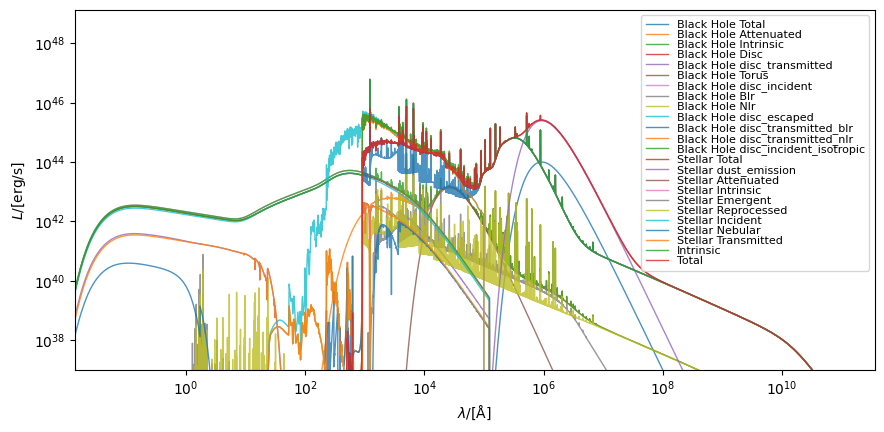

In [14]:
fig, ax = galaxy.plot_spectra(
    combined_spectra=True,
    stellar_spectra=True,
    black_hole_spectra=True,
    quantity_to_plot="luminosity",
    figsize=(10, 6),
)

### Images

To make iamges we need filters to define the photometry. For details see the [filter](../filters/filters.rst) and [imaging](../imaging/imaging.rst) docs.

In [15]:
filters = UVJ(new_lam=grid.lam)

With the spectra and filters made we can make images of each component and combine them.

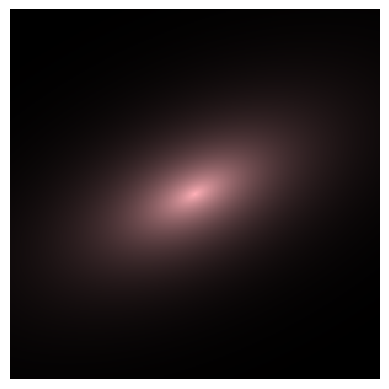

In [16]:
# Get photometry
galaxy.stars.spectra["total"].get_photo_lnu(filters)
galaxy.black_holes.spectra["total"].get_photo_lnu(filters)

# Make images
img = galaxy.get_images_luminosity(
    resolution=resolution,
    stellar_photometry="total",
    blackhole_photometry="total",
    fov=fov,
)

# Make and plot an rgb image
img.make_rgb_image(rgb_filters={"R": "J", "G": "V", "B": "U"})
fig, ax, _ = img.plot_rgb_image(show=True)